# 1. Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

plt.style.use('ggplot')

In [2]:
fnames = ["data/LoanStats_2018Q{}.csv".format(i) for i in range(1, 5)]
loans = [pd.read_csv(fname, skiprows=1, low_memory=False) for fname in fnames]
loans_no_footer = [loan.drop(loan.tail(2).index) for loan in loans]
df = pd.concat(loans_no_footer, keys=["Q1", "Q2", "Q3", "Q4"])

# 2. Initial exploration

Initially we are interested in answering the following four questions:

## a. What are the total number of loans?

In [3]:
print("There are {} loans in total.".format(df.shape[0]))

There are 495242 loans in total.


## b. How many columns does the dataset have?

In [4]:
print("The dataset comprises {} columns.".format(df.shape[1]))

The dataset comprises 144 columns.


## c. How many columns contain missing data? What is the count of missing data for each of these columns?

In [5]:
miss_by_col = df.isna().sum()
print("{} columns contain missing data.".format(len(miss_by_col[miss_by_col > 0])))

62 columns contain missing data.


The following table shows the count of missing data for each of these columns.

In [6]:
with pd.option_context('display.max_rows', None):
    display(miss_by_col[miss_by_col > 0])

id                                            495242
member_id                                     495242
emp_title                                      54659
emp_length                                     41987
url                                           495242
desc                                          495242
dti                                             1132
mths_since_last_delinq                        276652
mths_since_last_record                        432258
revol_util                                       592
last_pymnt_d                                     636
next_pymnt_d                                   85562
last_credit_pull_d                                 5
mths_since_last_major_derog                   380409
annual_inc_joint                              426257
dti_joint                                     426257
verification_status_joint                     431231
mths_since_rcnt_il                             18410
il_util                                       

## d. How many loans are still current?

In [7]:
print("{} loans are still current.".format(len(df[df["loan_status"] == "Current"])))

395475 loans are still current.


# 3. Preprocessing dataset

In this section I subset the dataset to only include "fully paid" or "charged off" loans. I also take this opportunity to remove columns that contain no data at all.

In [8]:
df = df[(df["loan_status"] == "Fully Paid") | (df["loan_status"] == "Charged Off")]
df["loan_status"].unique() # sanity check

array(['Fully Paid', 'Charged Off'], dtype=object)

In [9]:
df.dropna(axis=1, how='all', inplace=True)

# 4. Exploratory Data Analysis

Bearing our ultimate objective (predicting the probability of a loan being charged off) in mind, in this section I will explore the data and attempt to answer the following questions:

1. What proportion of loans are fully paid / charged off?

2. What is the distribution of several potential explanatory variables (e.g. `loan_amnt`, `annual_inc`, etc.) across loan status? 

3. For numerical variables, do they correlate with one another? With `loan_status`?


**In the interest of this challenge, see [TL;DR below](#Short-summary) for a short summary of things I think is worth knowing.**

## Overview

A quick and dirty look at the first few rows of each quarter.

In [10]:
with pd.option_context('display.max_columns', None):
    display(df.head())

loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  \
Q1 11    10000.0      10000.0          10000.0   60 months   14.07%   
   16     7000.0       7000.0           7000.0   36 months   11.98%   
   17    20000.0      20000.0          20000.0   60 months   26.77%   
   20    21000.0      21000.0          21000.0   60 months   20.39%   
   23    30000.0      30000.0          30000.0   36 months    7.34%   

       installment grade sub_grade                emp_title emp_length  \
Q1 11       233.05     C        C3                  Teacher    4 years   
   16       232.44     B        B5                   Parole   < 1 year   
   17       607.97     E        E5  Mental Health Provider     3 years   
   20       560.94     D        D4         Machine operator  10+ years   
   23       930.99     A        A4                    Owner    3 years   

      home_ownership  annual_inc verification_status   issue_d  loan_status  \
Q1 11           RENT     42000.0     Source Verified  Mar-2018   Fully Paid   
   16       MORTGAGE     40000.0            Verified  Mar-2018   Fully Paid   
   17           RENT     33500.0        Not Verified  Mar-2018  Charged Off   
   20            OWN     85000.0     Source Verified  Mar-2018   Fully Paid   
   23            OWN     95000.0            Verified  Mar-2018   Fully Paid   

      pymnt_plan           purpose             title zip_code addr_state  \
Q1 11          n    major_purchase    Major purchase    341xx         FL   
   16          n  home_improvement  Home improvement    797xx         TX   
   17          n             house       Home buying    604xx         IL   
   20          n             house       Home buying    135xx         NY   
   23          n             house       Home buying    797xx         TX   

         dti  delinq_2yrs earliest_cr_line  inq_last_6mths  \
Q1 11  24.69          0.0         Oct-2004             0.0   
   16  20.25          0.0         Mar-2007             0.0   
   17  24.40          0.0         Aug-2008             1.0   
   20  15.76          1.0         Nov-2008             0.0   
   23  16.18          1.0         Oct-2009             0.0   

       mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  \
Q1 11                    32.0                     NaN      17.0      0.0   
   16                    60.0                     NaN      13.0      0.0   
   17                     NaN                     NaN      27.0      0.0   
   20                     2.0                     NaN      15.0      0.0   
   23                    10.0                     NaN      10.0      0.0   

       revol_bal revol_util  total_acc initial_list_status  out_prncp  \
Q1 11      707.0      15.7%       34.0                   w        0.0   
   16     5004.0        36%       29.0                   w        0.0   
   17     7364.0        46%       34.0                   w        0.0   
   20    14591.0      34.2%       27.0                   w        0.0   
   23      755.0         0%       20.0                   w        0.0   

       out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  \
Q1 11            0.0  11153.669505         11153.67         10000.00   
   16            0.0   7693.314943          7693.31          7000.00   
   17            0.0   7236.150000          7236.15          2195.37   
   20            0.0  24217.170915         24217.17         21000.00   
   23            0.0  31484.416866         31484.42         30000.00   

       total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee  \
Q1 11        1153.67                 0.0         0.0                      0.0   
   16         693.31                 0.0         0.0                      0.0   
   17        5040.78                 0.0         0.0                      0.0   
   20        3217.17                 0.0         0.0                      0.0   
   23        1484.42                 0.0         0.0                      0.0   

      last_pym

In [11]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 85562 entries, (Q1, 11) to (Q4, 128407)
Data columns (total 139 columns):
loan_amnt                                     85562 non-null float64
funded_amnt                                   85562 non-null float64
funded_amnt_inv                               85562 non-null float64
term                                          85562 non-null object
int_rate                                      85562 non-null object
installment                                   85562 non-null float64
grade                                         85562 non-null object
sub_grade                                     85562 non-null object
emp_title                                     77231 non-null object
emp_length                                    78154 non-null object
home_ownership                                85562 non-null object
annual_inc                                    85562 non-null float64
verification_status                           85562 non

**Observations**


* `loan_amnt` (how much the borrower wanted loan), `funded_amnt` (what they actually got), `funded_amnt_inv` (how much of what they got came from investors) are all the same in the above cases, though further exploration is needed to see if this is indeed the case for everyone. Similar observations apply for `total_pymnt` and `total_pymnt_inv`.


* `installment` can easily be derived from `funded_amnt`, `term`, `int_rate`, and gives no additional information. Similarly, `grade` can be easily derived from `sub_grade`, `total_pymnt` from `total_rec_prncp`, `total_rec_int`, and `total_rec_late_fee`, etc.


* There is a clear dependence structure between some variables. For example, the presence of all `hardship_*` and `settlement_*` variables clearly depend on `hardship_flag` and `debt_settlement_flag` being `Y` respectively. Given the small number of cases ([see above](#c.-How-many-columns-contain-missing-data?-What-is-the-count-of-missing-data-for-each-of-these-columns?)) I will only retain the flag itself to simplify our model.


* Some variables will benefit from having their data type changed (e.g. `int_rate` can and should be represented as `float`). We do so now.


* Many variables have missing values, which can hinder modelling later on.

In [12]:
df['int_rate'] = pd.to_numeric(df['int_rate'].str.replace("%", ""))
df['revol_util'] = pd.to_numeric(df['revol_util'].str.replace("%", ""))
df['emp_length'] = pd.to_numeric(df['emp_length'].replace("[^0-9]+", "", regex=True))

In [13]:
for col in ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d', 'sec_app_earliest_cr_line']:
    df[col] = pd.to_datetime(df[col])

In [14]:
df['debt_settlement_flag'] = df['settlement_status'].notna()
df['hardship_flag'] = df['hardship_status'].notna()

df.drop(
    columns=[
        'hardship_type', 
        'hardship_reason', 
        'hardship_status', 
        'deferral_term', 
        'hardship_amount', 
        'hardship_start_date',
        'hardship_end_date',
        'payment_plan_start_date',
        'hardship_length',
        'hardship_dpd',
        'hardship_loan_status',
        'orig_projected_additional_accrued_interest',
        'hardship_payoff_balance_amount',
        'hardship_last_payment_amount'
    ],
    inplace=True,
    errors='ignore'
)

df.drop(
columns=[
        'debt_settlement_flag_date',
        'settlement_status', 
        'settlement_date', 
        'settlement_amount', 
        'settlement_percentage', 
        'settlement_term',
    ],
    inplace=True,
    errors='ignore'
)

## Summary statistics

In [15]:
with pd.option_context('display.max_columns', None):
    display(df.describe())
    display(df.describe(exclude=np.number))

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
count,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,78154.000000,8.556200e+04,85337.000000,85562.000000,85562.000000,38570.000000,12837.000000,85562.000000,85562.000000,8.556200e+04,85435.000000,85562.000000,85562.0,85562.0,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,20920.000000,85562.0,1.085100e+04,10851.000000,85562.000000,8.556200e+04,8.556200e+04,85562.000000,85562.000000,85562.000000,85562.000000,82708.000000,8.556200e+04,71662.000000,85562.000000,85562.000000,85562.000000,85535.000000,8.556200e+04,85562.000000,85562.000000,85562.000000,85562.000000,85553.000000,84148.000000,84084.000000,85562.000000,85562.000000,82708.000000,85562.000000,85562.000000,85562.000000,85562.000000,84249.000000,17723.000000,78257.000000,25477.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,83221.0,85562.000000,85562.000000,85562.000000,85561.000000,84147.000000,85562.000000,85562.000000,8.556200e+04,8.556200e+04,85562.000000,8.556200e+04,10851.000000,10851.000000,10851.000000,10851.000000,10646.000000,10851.000000,10851.000000,10851.000000,10851.000000,3742.000000
mean,14989.365314,14989.365314,14985.916641,13.380230,448.553353,5.969432,7.959393e+04,18.725496,0.235911,0.543477,36.891211,82.541092,11.408324,0.160246,1.441991e+04,39.905829,23.897466,0.0,0.0,13249.897239,13246.718741,12108.899670,989.251016,1.026301,150.720265,26.751885,9365.897448,0.017578,46.120172,1.0,1.255817e+05,18.932469,0.000058,3.351520e+02,1.519912e+05,1.063276,2.651107,0.854655,1.831619,18.052341,3.616911e+04,71.073623,1.378790,2.890162,5312.602300,52.843316,3.749388e+04,1.324022,1.728419,2.356455,5.060541,14854.216638,15963.571232,45.315080,0.008625,3.333957,121.258971,172.202403,13.626610,7.553201,1.505061,23.375838,40.657169,6.633886,37.902971,0.497955,3.313819,4.948844,4.751151,7.337159,8.767958,8.090531,13.420233,4.901440,11.383044,0.0,0.000058,0.063486,2.391459,94.698247,29.428115,0.144363,0.015731,1.927845e+05,5.080898e+04,25908.109558,4.546989e+04,33072.833103,0.715326,1.680859,11.298498,55.066804,2.918533,12.748779,0.049765,0.077597,37.251737
std,10031.851554,10031.851554,10031.267111,5.484391,291.114836,3.592520,7.392400e+04,20.233720,0.745523,0.793411,21.824540,23.746312,5.912563,0.450127,2.141680e+04,25.459298,12.645376,0.0,0.0,10677.728658,10676.667118,10267.150478,1086

,term,grade,sub_grade,emp_title,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,verification_status_joint,sec_app_earliest_cr_line,hardship_flag,debt_settlement_flag
count,85562,85562,85562,77231,85562,85562,85562,85562,85562,85562,85562,85562,85562,85562,85562,84926,85560,85562,10462,10851,85562,85562
unique,2,7,35,31586,4,3,12,2,1,13,12,875,50,633,2,18,20,2,3,538,2,2
top,36 months,B,B5,Manager,MORTGAGE,Source Verified,2018-01-01 00:00:00,Fully Paid,n,debt_consolidation,Debt consolidation,945xx,CA,2006-08-01 00:00:00,w,2019-01-01 00:00:00,2019-06-01 00:00:00,Individual,Not Verified,2006-08-01 00:00:00,False,False
freq,62999,23267,5080,1493,43144,34278,10976,69775,85562,44625,44625,934,12382,758,71459,8631,37030,74711,4751,120,85467,84560
first,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1950-01-01 00:00:00,NaN,2018-01-01 00:00:00,2017-11-01 00:00:00,NaN,NaN,1961-01-01 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01 00:00:00,NaN,2019-06-01 00:00:00,2019-06-01 00:00:00,NaN,NaN,2018-03-01 00:00:00,NaN,NaN


**Observations**

* All borrowers were indeed issued the full amount that they requested, confirming my suspicions above. However, a minority of them were not fully funded by investors for some reason. Regardless, we can safely remove `funded_amnt`.


* Most loans were given to borrowers who have not been delinquent at all for the past 2 years, and more than half  were given to borrowers who were never delinquent (or missing delinquency data). On the other extreme, at least one borrower has racked up almost 400k USD worth of credit card debt (`max_bal_bc`)!


* The mean debt-to-income (DTI) ratio, excluding mortgages and the current loan is 19%. This implies that the average borrower spent almost a fifth of their income monthly towards repaying their debt obligations.


* Some variables such as `out_prncp` and `pymnt_plan` clearly provides no discriminating information, and thus can be safely removed. These variables are listed (and removed) below.


* With only 85k rows of data and almost 900 unique `zip_code`s, inferences made with zip code will unlikely be reliable. I will use a [modified version](https://www.ducksters.com/geography/us_states/us_geographical_regions.php) of `addr_state` (grouping them into "major regions") to infer spatial variation in loan status. 


* Similarly, with over 30k unique `emp_title`, we are unlikely to make any valid inferences with it. I will drop them in favour of `annual_inc` instead.


* `sub_grade` might be better represented as integers (with `A1` being 1 and `G5` being 35).


In [16]:
df.drop(columns=['funded_amnt', 'zip_code', 'title', 'emp_title'], axis=1, inplace=True, errors='ignore')

In [17]:
with pd.option_context('display.max_rows', None):
    unique_elems = df.nunique()
    display(unique_elems[unique_elems == 1])
    
df.drop(columns = unique_elems[unique_elems == 1].index, inplace=True, errors='ignore')

pymnt_plan          1
out_prncp           1
out_prncp_inv       1
policy_code         1
num_tl_120dpd_2m    1
dtype: int64

In [18]:
def get_region(state):
    if state in ['CT', 'MA', 'MD', 'ME', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']:
        return 'NE'
    elif state in ['AL', 'AR', 'DC', 'DE', 'FL', 'GA', 'KY', 'LA', 'MS', 'NC', 'SC', 'TN', 'VA', 'WV']:
        return 'SE'
    elif state in ['IA', 'IL', 'IN', 'KS', 'MI', 'MN', 'MO', 'ND', 'NE', 'OH', 'SD', 'WI']:
        return 'MW'
    elif state in ['AZ', 'NM', 'OK', 'TX']:
        return 'SW'
    elif state in ['AK', 'CA', 'CO', 'HI', 'ID', 'MT', 'NV', 'OR', 'UT', 'WA', 'WY']:
        return 'W'
    return state

In [19]:
df['region'] = df['addr_state'].apply(get_region)
df.drop('addr_state', axis=1, inplace=True, errors='ignore')
df['region'].describe() # sanity check

count     85562
unique        5
top           W
freq      21340
Name: region, dtype: object

In [20]:
def numerify(sub_grade):
    baseline = ord('A') - 1
    return (ord(sub_grade[0]) - baseline) * int(sub_grade[1])

In [21]:
df['grade'] = df['sub_grade'].apply(numerify)
df.drop('sub_grade', axis=1, inplace=True, errors='ignore')
df['grade'].describe() # sanity check

count    85562.000000
mean         7.659639
std          5.349081
min          1.000000
25%          4.000000
50%          6.000000
75%         10.000000
max         35.000000
Name: grade, dtype: float64

## What proportion of loans are fully paid / charged off?

In [22]:
df['loan_status'].value_counts() / len(df)

Fully Paid     0.815491
Charged Off    0.184509
Name: loan_status, dtype: float64

**Observations**

* Our dataset is imbalanced - majority of the loans are fully paid. We should keep this in mind when evaluating our model - a useless model that predicts all loans will be fully paid will have an accuracy of 81.5\% here!

## What is the distribution of several potential explanatory variables (e.g. `loan_amnt`, `annual_inc`, etc.) across loan status? 

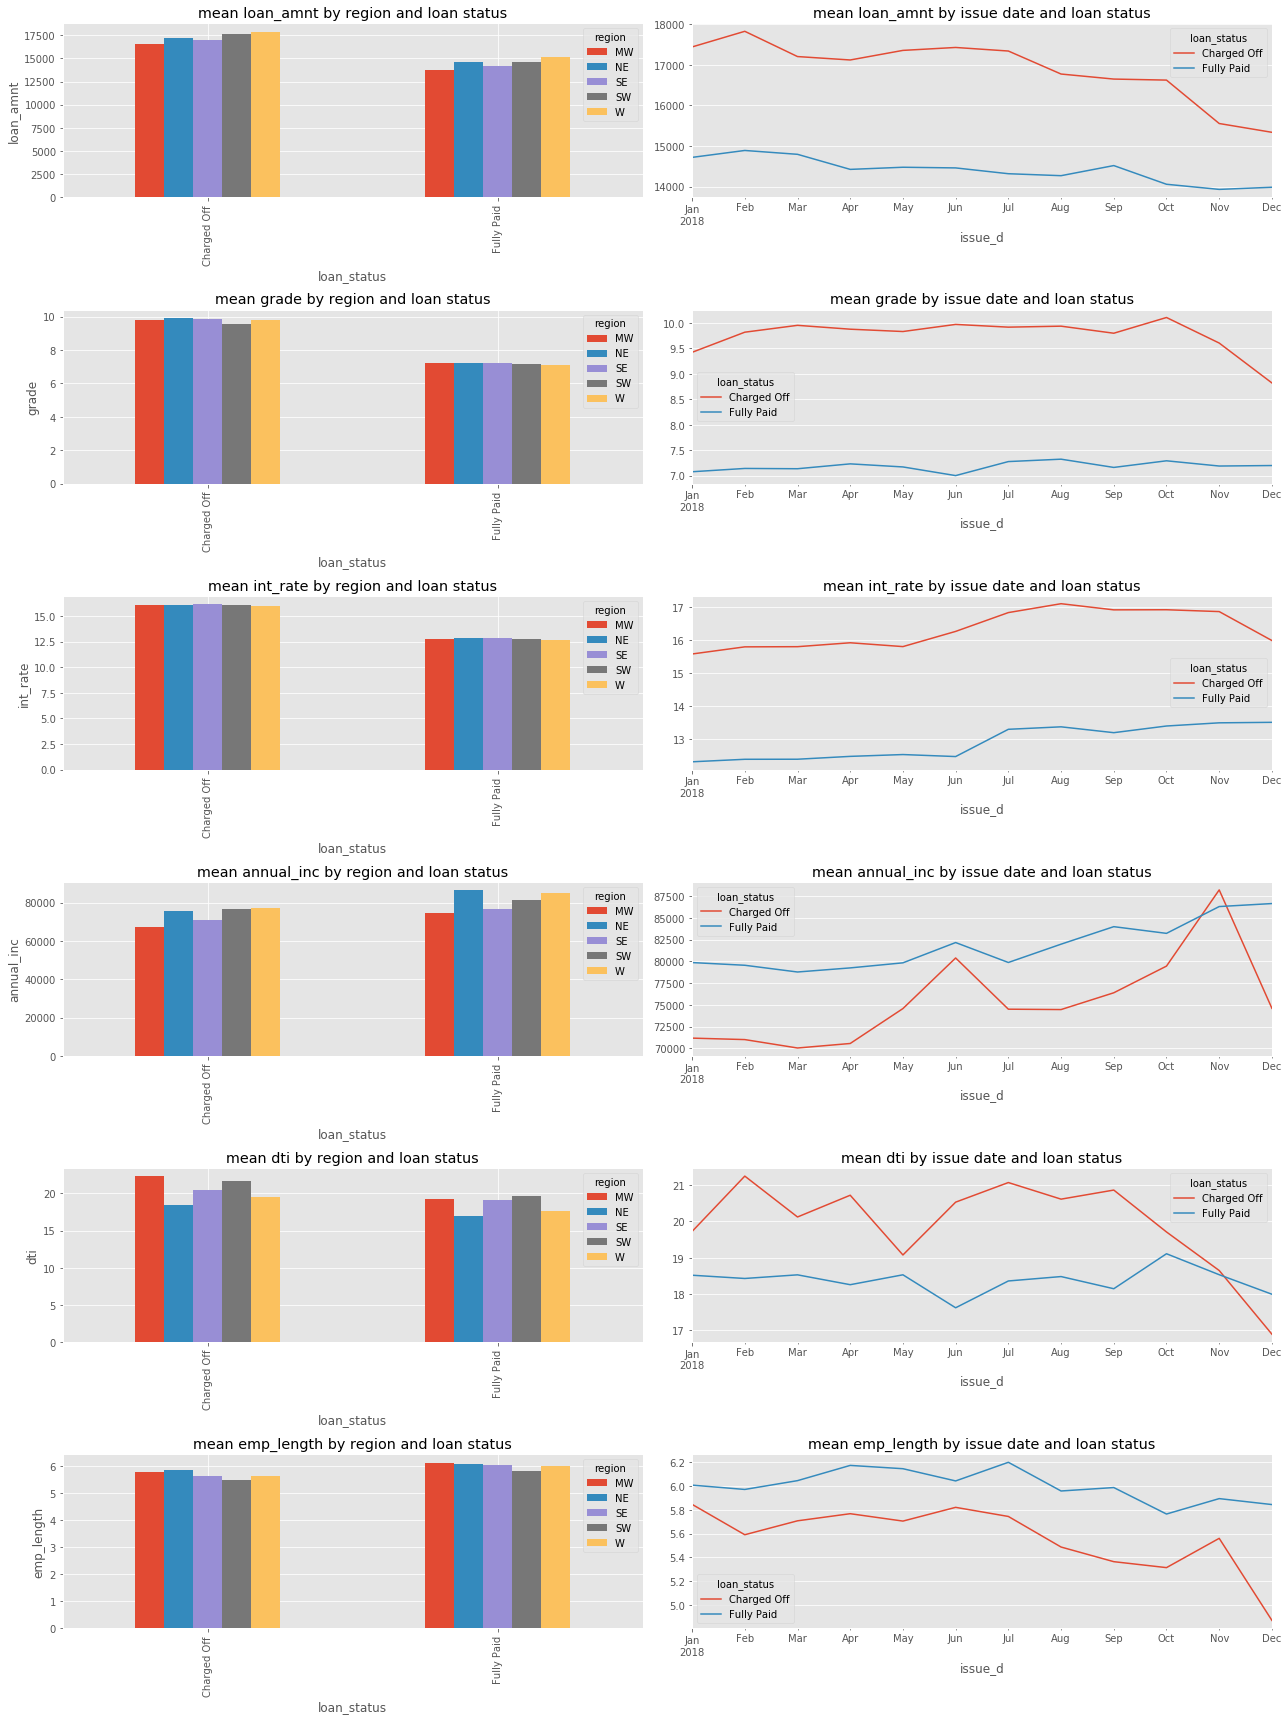

In [23]:
exp_vars_num = ['loan_amnt', 'grade', 'int_rate', 'annual_inc', 'dti', 'emp_length']
isco_loc_df = df.groupby(['loan_status', 'region'])
isco_time_df = df.groupby(['issue_d', 'loan_status'])

fig, ax = plt.subplots(len(exp_vars_num), 2, figsize=(3 * len(exp_vars_num), 4 * len(exp_vars_num)))

for idx, var in enumerate(exp_vars_num):
    isco_loc_df[var].mean().unstack().plot(kind='bar', ax=ax[idx][0])
    isco_time_df[var].mean().unstack().plot(kind='line', ax=ax[idx][1])
    ax[idx][0].set_title('mean {} by region and loan status'.format(var))
    ax[idx][1].set_title('mean {} by issue date and loan status'.format(var))
    ax[idx][0].set_ylabel(var)

plt.tight_layout()
plt.show()

**Observations**

* The interaction plots on the left show that there are no discernable interaction effects between `region` and the variables of interest.


* However, it would appear that the average borrowers from `NE` and `W` regions have considerably lower debt-to-income ratio than others, although this could be partially explained by the fact that they have higher average annual income.


* The plots on the right show that there are clear differences in the average value of several variables between loans that are fully paid and charged off.

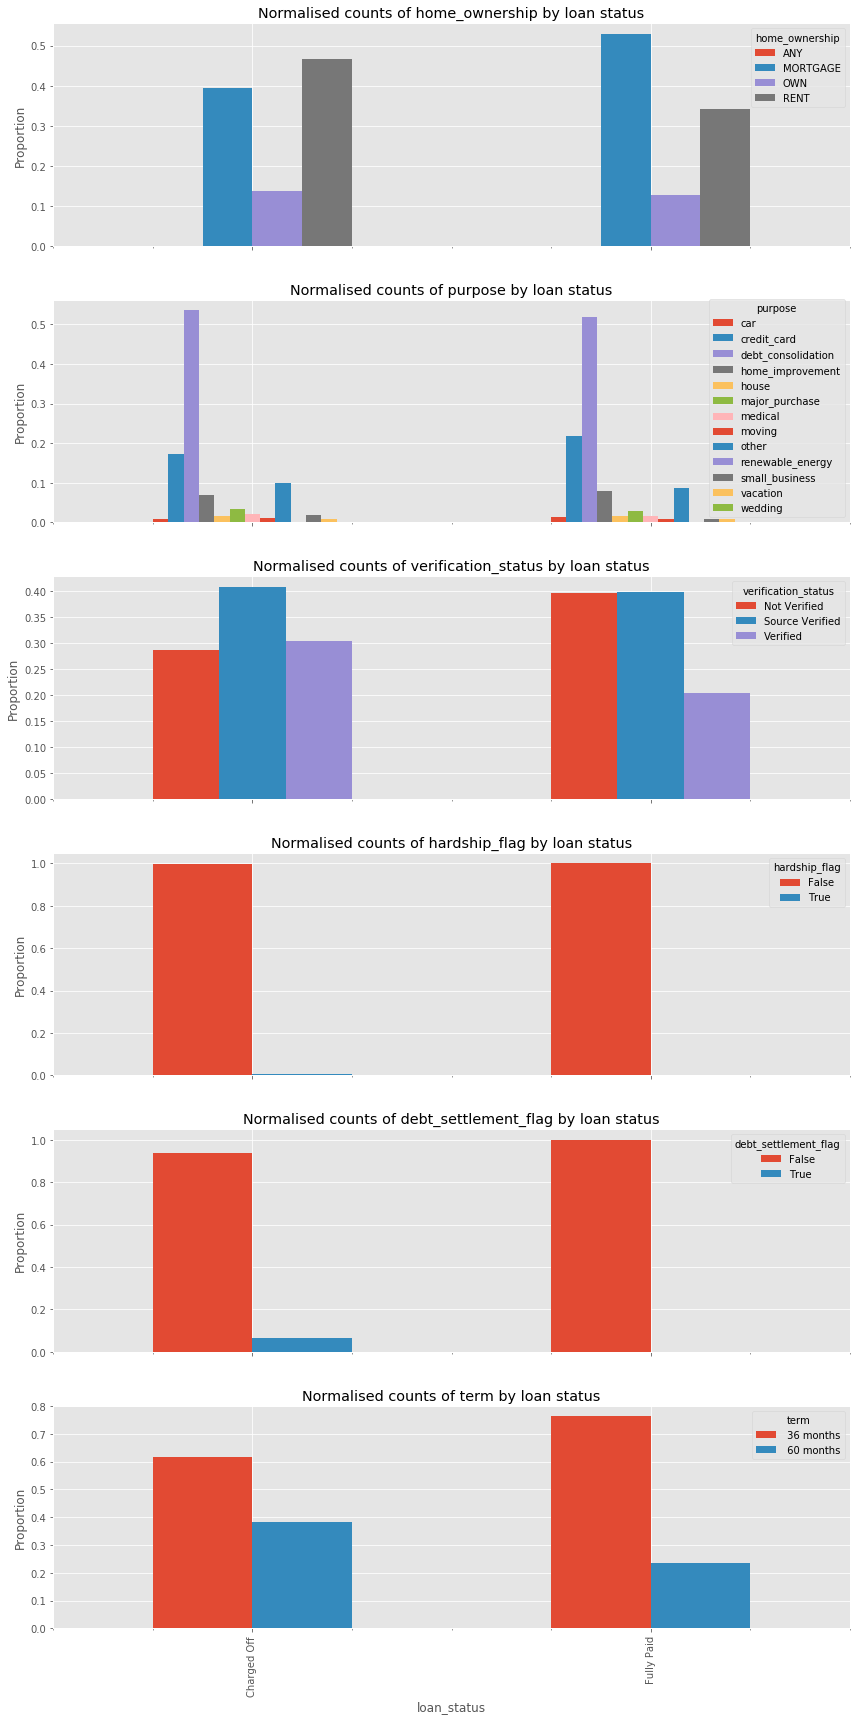

In [24]:
exp_vars_cat = ['home_ownership', 'purpose', 'verification_status', 'hardship_flag', 'debt_settlement_flag', 'term']
isco_df = df.groupby('loan_status')

fig, ax = plt.subplots(len(exp_vars_cat), figsize=(2 * len(exp_vars_cat), 4 * len(exp_vars_cat)), sharex=True)

for idx, var in enumerate(exp_vars_cat):
    isco_df[var].value_counts(normalize=True).unstack().plot(kind='bar', ax=ax[idx])
    ax[idx].set_title("Normalised counts of {} by loan status".format(var))
    ax[idx].set_ylabel("Proportion")

plt.tight_layout()
plt.show()

**Observations**

* Loans that are fully paid tend to come from borrowers living on a mortgaged property. Conversely, loans that are charged off tend to come from renters.


* Somewhat surprisingly, there does not appear to be any discernible difference in the distribution of `purpose` across both loan statuses. This implies a lack of discriminatory power.


* Unexpectedly, there is a higher proportion of borrowers with unverified income among those who fully paid their loans than among those whose loans were charged off!


* `hardship_flag` and `debt_settlement_flag` are as I suspected previously strong indicators of whether a loan is fully paid or charged off.


* Loans that are fully paid tend to be those with shorter terms. This is unsurprising as loans with longer terms are likely to be bigger and more difficult to pay off.

## For numerical variables, do they correlate with one another?

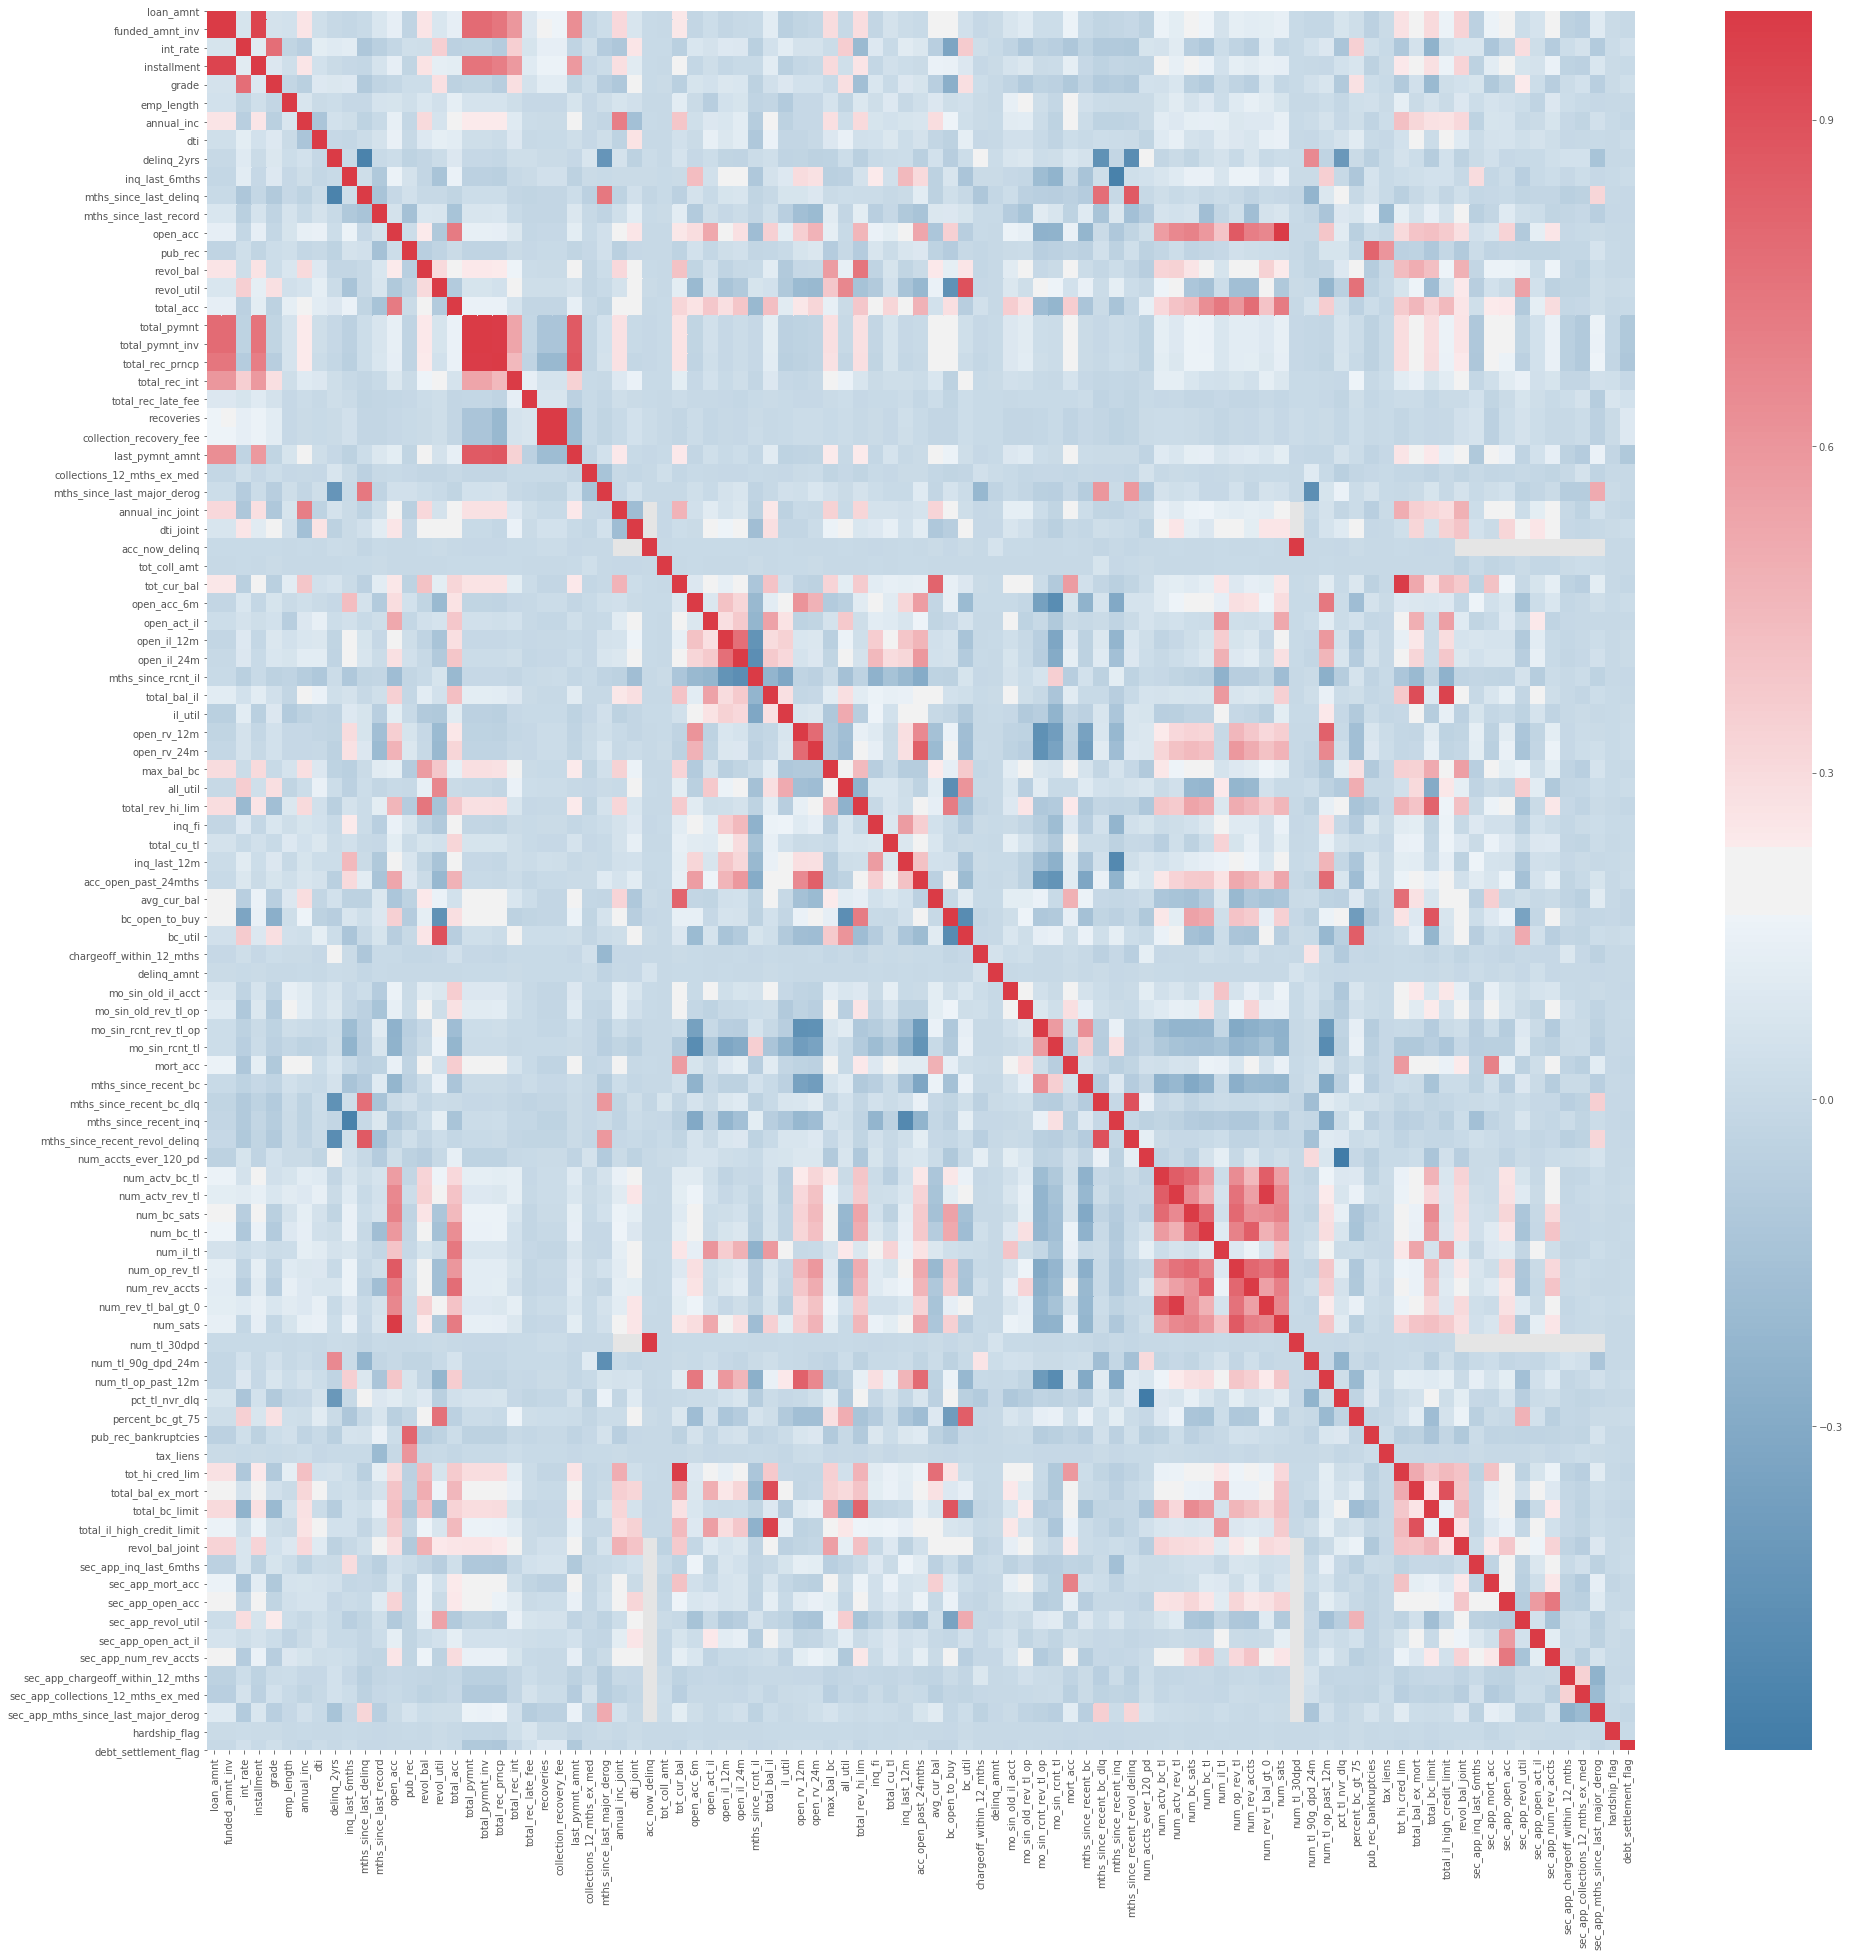

In [25]:
_, ax = plt.subplots(figsize=(32, 32))
corr = df.corr()
sns.heatmap(corr, ax=ax, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(240, 10, as_cmap=True))
plt.show()

**Observations** 

**NB: Right click on the image to save it and be able to zoom in**

* There are clearly several groups of strongly correlated variables, such as (but not limited to)
    * `loan_amnt`, `funded_amnt_inv`
    * `total_pymnt`, `total_pymnt_inv`, `total_rec_prncp`, `last_paymnt_amnt`
    * `recoveries`, `collection_recovery_fee`


* Knowing how variables correlate with one another is an important step towards reducing the number of features, minimising the effects of "curse of dimensionality" and increasing the reliability of our inference. 

## What about with `loan_status`?

In [26]:
le = LabelEncoder()
df['loan_status'] = le.fit_transform(df['loan_status'])
df['loan_status'].value_counts(normalize=True) # 0: Charged Off, 1: Fully Paid

1    0.815491
0    0.184509
Name: loan_status, dtype: float64

In [27]:
print('Top 10 positively correlated variables')
display(df.corr()['loan_status'].sort_values(ascending=False).head(10))
print('Top 10 negatively correlated variables')
display(df.corr()['loan_status'].sort_values().head(10))

Top 10 positively correlated variables


loan_status                            1.000000
total_rec_prncp                        0.486008
last_pymnt_amnt                        0.440231
total_pymnt                            0.430540
total_pymnt_inv                        0.430470
sec_app_mths_since_last_major_derog    0.141648
sec_app_mort_acc                       0.139905
tot_hi_cred_lim                        0.102650
mort_acc                               0.098776
tot_cur_bal                            0.092910
Name: loan_status, dtype: float64

Top 10 negatively correlated variables


recoveries                -0.426826
collection_recovery_fee   -0.424135
int_rate                  -0.235054
debt_settlement_flag      -0.228850
grade                     -0.191201
total_rec_late_fee        -0.156570
sec_app_inq_last_6mths    -0.139437
sec_app_revol_util        -0.128394
dti_joint                 -0.110941
installment               -0.110771
Name: loan_status, dtype: float64

**Observations** 

* The list above is more or less expected, except perhaps that `sec_app_inq_last_6mths`, `sec_app_revol_util`, and `dti_joint` are all more strongly correlated than `inq_last_6mths`, `revol_util`, and `dti`. This could suggest that more often than not it is the secondary applicants that are more risky.

* To compress this information I will combine as many primary and secondary information below.

In [28]:
# List of all secondary information
print([col for col in df.columns if 'sec_app_' in col or '_joint' in col])

['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog']


In [29]:
for pri in ['mths_since_last_major_derog', 'earliest_cr_line']:
    sec = "sec_app_{}".format(pri)
    df[pri] = df[[pri, sec]].min(axis=1)
    df.drop(columns=sec, inplace=True)

for pri in [
    'chargeoff_within_12_mths', 
    'collections_12_mths_ex_med', 
    'num_rev_accts', 
    'inq_last_6mths', 
    'mort_acc', 
    'open_acc', 
    'open_act_il'
]:
    sec = "sec_app_{}".format(pri)
    df[pri] = df[[pri, sec]].sum(axis=1)
    df.drop(columns=sec, inplace=True)

for pri in ['annual_inc', 'revol_bal', 'revol_util', 'dti']:
    if pri == 'revol_util':
        sec = "sec_app_{}".format(pri)
    else:
        sec = "{}_joint".format(pri)
        
    df[pri] = df[[pri, sec]].max(axis=1)
    df.drop(columns=sec, inplace=True)
    
condlist = [
    df['verification_status_joint'].notna(),
    df['verification_status_joint'].isna()
]
choicelist = [
    df['verification_status_joint'],
    df['verification_status']
]
df['verification_status'] = np.select(condlist, choicelist, default=df['verification_status'])
df.drop(columns='verification_status_joint', inplace=True)

In [30]:
with pd.option_context('display.max_rows', None):
    display(df.isnull().sum(axis=0)[df.isnull().sum(axis=0) > 0].sort_values(ascending=False))

mths_since_last_record            72725
mths_since_recent_bc_dlq          67839
mths_since_last_major_derog       62397
mths_since_recent_revol_delinq    60085
mths_since_last_delinq            46992
il_util                           13900
emp_length                         7408
mths_since_recent_inq              7305
mo_sin_old_il_acct                 2854
mths_since_rcnt_il                 2854
bc_util                            1478
percent_bc_gt_75                   1415
bc_open_to_buy                     1414
mths_since_recent_bc               1313
last_pymnt_d                        636
revol_util                          105
all_util                             27
avg_cur_bal                           9
last_credit_pull_d                    2
pct_tl_nvr_dlq                        1
dtype: int64

## Short summary